# SDP-LMC Queue Connector - RCAL Gain Calibrations Example

This notebook contains demonstration configurations of a LMC Queue Connector between an SDP Jones Solver and Receptor Tango Devices using interfaces outlined in ADR-58.



Legend:

* s: Subarray ID
* k: Kafka Topic ID
* x: Beam ID
* y: channel chunk ID

In [ ]:
import os

KUBE_NAMESPACE = "<insert-namespace-here>"

# set the host names of the database and tango services
DATABASEDS_NAME = "databaseds-tango-base"
KAFKA_HOST = f"ska-sdp-kafka.{KUBE_NAMESPACE}.svc.cluster.local"
os.environ["SDP_CONFIG_HOST"] = f"ska-sdp-etcd-client.{KUBE_NAMESPACE}"
os.environ["TANGO_HOST"] = f"{DATABASEDS_NAME}.{KUBE_NAMESPACE}.svc.cluster.local:10000"

In [ ]:
import logging
import tango
import ska_sdp_config
import ska_ser_logging

logger = logging.getLogger(__name__)
ska_ser_logging.configure_logging(level=logging.INFO)


# Tango and Database Paths
qc = tango.DeviceProxy('test-sdp/queueconnector/01')
QC_CONFIG_PATH = '/component/lmc-queueconnector-01/owner'

config_db = ska_sdp_config.Config()

## Stream Calibration Solutions To Kafka split on Frequency Axis

Using multiple `TangoSplitAttributeSink` instances, it is possible to transfer solutions split on both Kafka and Tango messages. This is trivial to do using Kafka topics rather than a long sequence of Kafka messages and does not run the risk of sequence disrupts in addition to allowing for further hardware scaling.

For solutions with significant transfer times, splitting a single solution into multiple messages helps reduce the per-solution latency as later stages of the pipeline can start processing before it is fully buffered.



In [ ]:
import aiokafka
import numpy as np

async def mock_kafka_solutions(jones_shape: np.ndarray, max_kafka_channels: int, num_mock_solutions: int, dtype):
    kafka_channel_chunks = math.ceil(jones_shape[1] / max_kafka_channels)
    max_message_size = int(jones_shape.prod() * np.dtype(dtype).itemsize)

    async with aiokafka.AIOKafkaProducer(
        bootstrap_servers=KAFKA_HOST,
        max_request_size=max_message_size
    ) as producer:
        for solution in range(num_mock_solutions):
            data = np.full(jones_shape, solution+1, dtype=dtype)
            data_chunks = np.array_split(data, kafka_channel_chunks, axis=1)
            for topic_id, data_chunk in enumerate(data_chunks):
                await producer.send_and_wait(f"jones_0_{topic_id}", data_chunk.data)


## Queue Connector Config

Through the use of TangoArrayScatterAttributeSink, the Queue Connector will automatically handle dynamic axis scattering with shape attributes for supporting n-dimensional arrays through tango.

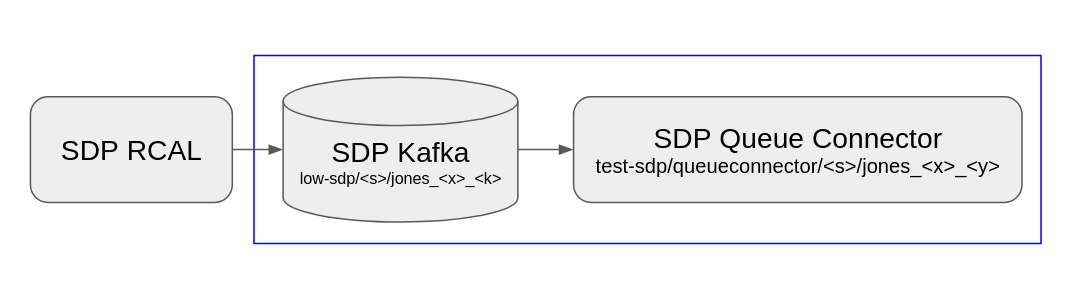

In [ ]:
import json
import numpy as np
import math

def create_config(jones_shape: list[int], max_kafka_channels: int, max_tango_channels: int, dtype: np.dtype):
    
    # NOTE: Assuming each kafka topic will be of equal size
    kafka_shape = np.array([jones_shape[0], max_kafka_channels, jones_shape[2], jones_shape[3], jones_shape[4]])
    kafka_channel_chunks = math.ceil(jones_shape[1] / max_kafka_channels)
    num_tango_chunks = math.ceil(max_kafka_channels / max_tango_channels)
    payloads_per_solution = kafka_channel_chunks * num_tango_chunks
    
    logger.info(f"Creating queue connector config for"
          f" {kafka_channel_chunks} kafka topics,"
          f" {kafka_channel_chunks * num_tango_chunks} tango attributes"
    )
    
    config = { "exchanges": [
        {
            # Connect Kafka messages to Tango array attribute
            "dtype": dtype,
            "shape": kafka_shape.tolist(),
            "source": {
                "type": "KafkaConsumerSource",
                "topic": f"jones_0_{k}",
                "servers": KAFKA_HOST,
                "encoding": "carray"
            },
            "sink": {
                "type": "TangoArrayScatterAttributeSink",
                "attribute_names": [
                    f"jones_0_{y}"
                    for y in range(k * num_tango_chunks, (k+1) * num_tango_chunks)
                ],
                "attribute_shape_names": [
                    f"jones_shape_0_{y}"
                    for y in range(k * num_tango_chunks, (k+1) * num_tango_chunks)
                ],
                "axis": 1,
                "default_value": 0.0
            }
        }
        for k in range(kafka_channel_chunks)
    ]}, payloads_per_solution
    return config

# Kafka to Tango Calibration Performance Test

Using configurable maximums for Kafka and Tango channels in the following cell, the number of topics and attributes required can be dynamically generated for both large and small subarray observations.

Using the following defaults, a full AA4 subarray gain calibration (64MiB) will be connected from Kafka topics to Tango attributes (4096 channels, 512 receptors) using 4 kafka topics and 32 tango attributes.

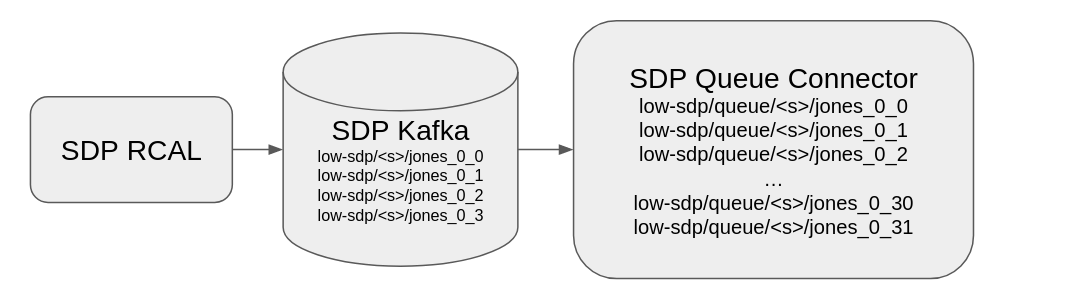

In [ ]:
# Tests Variables

SKA_LOW_JONES_SHAPE = np.array([1, 4096, 512, 4, 2])  # beams, channels, receptors, polarizations, complex
DTYPE="float32"
MAX_KAFKA_CHANNELS = 1024
MAX_TANGO_CHANNELS = 128

RCAL_CONFIG_PATH = f"{QC_CONFIG_PATH}/rcal"
NUM_MOCK_SOLUTIONS = 4

# Run Pipeline and Profile

In [ ]:
from contextlib import ExitStack
import asyncio
from functools import partial
from tango import EventType, DevState

from utils.tango_utils import (
    SubscribeEventConditionContext,
    SubscribeEventTensorContext
)
from utils.profiler_utils import (
    Profiler
)

loop = asyncio.get_running_loop()
received_queue = asyncio.Queue()
profiler = Profiler()

config, payloads_per_solution = create_config(
    jones_shape=SKA_LOW_JONES_SHAPE,
    max_kafka_channels=MAX_KAFKA_CHANNELS,
    max_tango_channels=MAX_TANGO_CHANNELS,
    dtype=DTYPE
)

display(config)

In [ ]:
logger.info("Resetting all pipelines...")
config_db.backend.delete(QC_CONFIG_PATH, recursive=True, must_exist=False)

logger.info("Configuring..")
with SubscribeEventConditionContext(qc, "State", EventType.CHANGE_EVENT) as device_state:
    config_db.backend.create(RCAL_CONFIG_PATH, json.dumps(config))
    await device_state.wait_for(DevState.OFF, timeout=1)
logger.info("Configured")

def tensor_receive_handler(name, tensor):
    logger.info(
        f"{name} subscription received {tensor.nbytes:,} bytes:"
        f" array({tensor.flatten()}, dtype={tensor.dtype}, shape={tensor.shape})")
    profiler.record(tensor.nbytes)
    asyncio.run_coroutine_threadsafe(received_queue.put(tensor), loop)

profiler.start()
with ExitStack() as stack:
    for y in range(payloads_per_solution):
        stack.enter_context(
            SubscribeEventTensorContext(
                proxy=qc,
                attr_name=f"jones_0_{y}",
                attr_shape_name=f"jones_shape_0_{y}",
                event_type=tango.EventType.CHANGE_EVENT,
                callback=partial(tensor_receive_handler, f"{qc.dev_name()}/jones_0_{y}")
            )
        )

    # NOTE: assuming kafka topics are evenly split
    await mock_kafka_solutions(SKA_LOW_JONES_SHAPE, 1024, NUM_MOCK_SOLUTIONS, dtype=DTYPE)
        
    while received_queue.qsize() < NUM_MOCK_SOLUTIONS * payloads_per_solution:
        await asyncio.sleep(0.1)
    
config_db.backend.delete(RCAL_CONFIG_PATH, recursive=True)
logger.info(profiler.report(num_chunk_messages=payloads_per_solution))
logger.info("Stopped")